# Setup & Load RFM base

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
rfm = pd.read_csv('../data/processed/rfm_base.csv')
rfm.head(), rfm.shape


(  CustomerID  Recency  Frequency  Monetary
 0   C1010011       26          2    5106.0
 1   C1010012       69          1    1499.0
 2   C1010014       76          2    1455.0
 3   C1010018       37          1      30.0
 4   C1010024       65          1    5000.0,
 (838903, 4))

In [18]:
# Data Check
rfm.info()
rfm.describe()[['Recency','Frequency','Monetary']]
rfm.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838903 entries, 0 to 838902
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerID  838903 non-null  object 
 1   Recency     838903 non-null  int64  
 2   Frequency   838903 non-null  int64  
 3   Monetary    838903 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 25.6+ MB


CustomerID    0
Recency       0
Frequency     0
Monetary      0
dtype: int64

# 2. RFM scoring (quartiles; Recency reversed)

In [19]:
# Handle ties for qcut on Frequency
rfm['_F_rank'] = rfm['Frequency'].rank(method='first')

rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)     # lower recency = better
rfm['F_Score'] = pd.qcut(rfm['_F_rank'], 4, labels=[1,2,3,4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm.drop(columns=['_F_rank'], inplace=True)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,C1010011,26,2,5106.0,4,4,4,444
1,C1010012,69,1,1499.0,2,1,4,214
2,C1010014,76,2,1455.0,1,4,4,144
3,C1010018,37,1,30.0,4,1,1,411
4,C1010024,65,1,5000.0,2,1,4,214


# Segment Mapping(Business Based)

In [20]:
def map_segment(r, f, m):
    if r>=3 and f>=3 and m>=3: return 'Best Customers'
    if r>=3 and f>=3 and m<=2: return 'Loyal (Lower Spend)'
    if r>=3 and f<=2 and m>=3: return 'Recent High-Spend'
    if r<=2 and f>=3:          return 'Needs Attention (Was Loyal)'
    if r<=2 and f<=2 and m>=3: return 'High-Value Inactive'
    if r>=3 and f<=2 and m<=2: return 'New/Promising'
    if r<=2 and f<=2 and m<=2: return 'At Risk'
    return 'Others'

rfm['Segment'] = rfm.apply(lambda x: map_segment(x['R_Score'], x['F_Score'], x['M_Score']), axis=1)

rfm['Segment'].value_counts()


Segment
Needs Attention (Was Loyal)    188659
Best Customers                 135929
At Risk                        123714
New/Promising                  110114
High-Value Inactive             99093
Loyal (Lower Spend)             94863
Recent High-Spend               86531
Name: count, dtype: int64

# Segment Profilling(Table)

In [21]:
profile = (rfm.groupby('Segment')
             .agg(Customers=('CustomerID','nunique'),
                  Avg_Recency=('Recency','mean'),
                  Avg_Frequency=('Frequency','mean'),
                  Avg_Monetary=('Monetary','mean'))
             .sort_values('Avg_Monetary', ascending=False))
profile


,Customers,Avg_Recency,Avg_Frequency,Avg_Monetary
Segment,,,,
Best Customers,135929,43.202981,1.665539,2908.015010
High-Value Inactive,99093,70.112722,1.000000,2529.268887
Recent High-Spend,86531,44.175764,1.000000,2527.388709
Needs Attention (Was Loyal),188659,69.171288,1.195188,1484.331816
Loyal (Lower Spend),94863,43.724139,1.199203,218.741753
At Risk,123714,69.796466,1.000000,203.082831
New/Promising,110114,44.004668,1.000000,202.178525


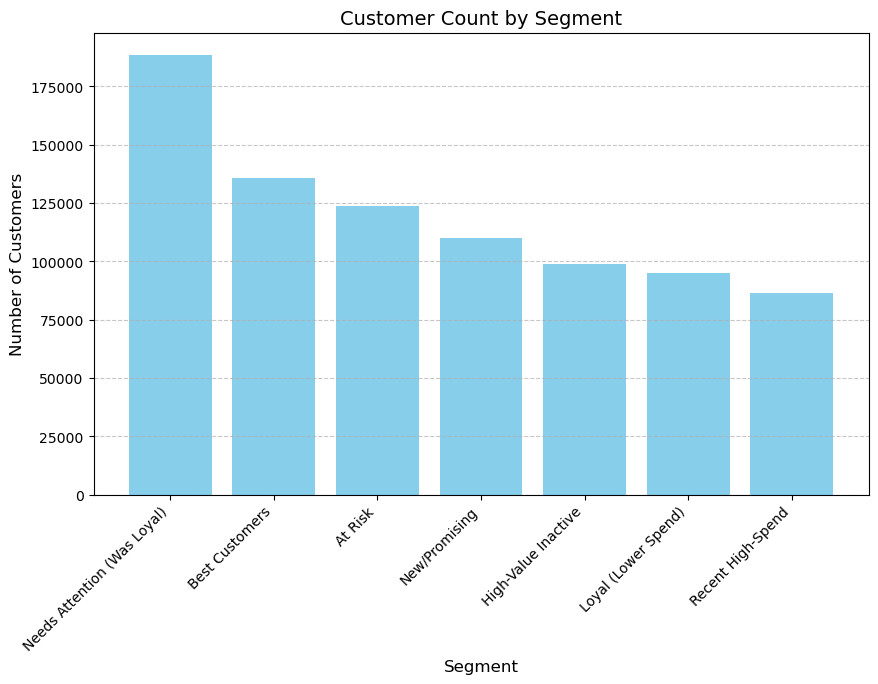

In [22]:
import matplotlib.pyplot as plt

# Sort by number of customers for clarity
profile_sorted = profile.sort_values('Customers', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(profile_sorted.index, profile_sorted['Customers'], color='skyblue')

plt.title('Customer Count by Segment', fontsize=14)
plt.xlabel('Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


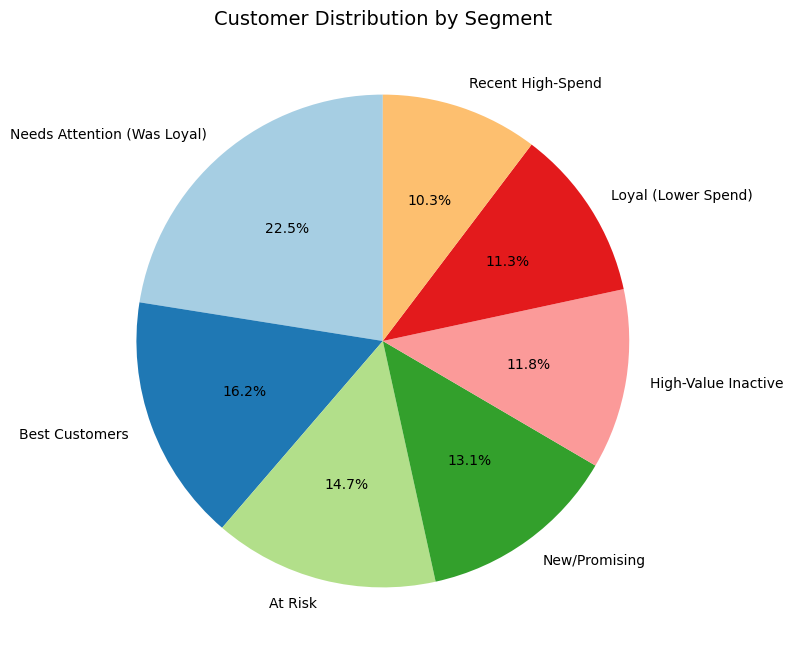

In [23]:
# Count number of customers per segment
segment_counts = rfm['Segment'].value_counts()

# Create pie chart
plt.figure(figsize=(8,8))
plt.pie(segment_counts,
        labels=segment_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Paired.colors)

plt.title('Customer Distribution by Segment', fontsize=14)
plt.show()


from IPython.display import Markdown, display

display(Markdown("""
### 🧩 Updated RFM Segmentation Summary (After Refinement)

| Segment | Interpretation | Suggested Action |
|----------|----------------|------------------|
| **Best Customers** | Customers who purchase frequently, spend high, and remain recent. They are your most loyal and profitable group. | Maintain loyalty with personalized offers, VIP treatment, and early access to new products. |
| **Loyal (Lower Spend)** | Repeat buyers who remain active but spend modestly per transaction. | Upsell or cross-sell complementary products to increase their average spend. |
| **Recent High-Spend** | Recently active customers who make big purchases but shop less frequently. | Encourage repeat engagement through loyalty rewards or time-sensitive offers. |
| **High-Value Inactive** | Historically valuable customers who spent heavily but are now inactive. | Re-engage through win-back campaigns, premium incentives, or personalized messages. |
| **At Risk** | Previously active customers who are reducing purchase frequency and recency. | Send retention emails or targeted reactivation offers before they churn fully. |
| **New/Promising** | Newer customers with low spend and frequency but good recent engagement. | Nurture with onboarding content, welcome discounts, or loyalty introductions. |
| **Needs Attention (Was Loyal)** | Customers showing significant drop in engagement after prior loyalty. | Analyze reasons for decline and re-engage with personalized retention strategies. |
"""))


## 💡 Business Insight & Recommended Actions

The refined RFM segmentation provides a clear picture of customer value distribution and engagement. A significant portion (over 60%) of customers fall into **“Needs Attention”**, **“At Risk”**, or **“High-Value Inactive”** categories — indicating a large opportunity to **reactivate and retain** valuable but disengaged users. Meanwhile, **Best Customers** and **Recent High-Spend** segments, though smaller, contribute the majority of revenue and should be prioritized for **loyalty and advocacy programs**.

### Key Insights:
- **Best Customers (16%)** – Highly engaged, frequent spenders driving premium value. They should be nurtured through loyalty schemes, VIP events, and personalized recognition.
- **Recent High-Spend (10%)** – New but valuable customers showing strong purchase intent. Quick follow-up with retention offers can secure their long-term loyalty.
- **Loyal (Lower Spend) (11%)** – Consistent buyers with lower basket size. Upselling and bundle offers could raise their average order value.
- **High-Value Inactive (12%)** – Historically top spenders who’ve lapsed. Reactivation campaigns (exclusive deals or “We miss you” emails) can recover lost revenue.
- **At Risk (15%)** – Reduced frequency and longer inactivity. Personalized outreach or service recovery initiatives are needed to prevent churn.
- **Needs Attention (23%)** – Customers drifting from engagement. Trigger re-engagement journeys (e.g., reminders, discounts, content-based emails).

### Strategic Actions:
- 📈 **Retention:** Develop targeted email and SMS campaigns for “At Risk” and “Needs Attention” groups.  
- 🤝 **Loyalty:** Offer early access, rewards, or premium experiences for “Best Customers” and “Recent High-Spend.”  
- 🔁 **Reactivation:** Launch win-back offers for “High-Value Inactive” to revive dormant accounts.  
- 🎯 **Growth:** Focus marketing spend on converting “New/Promising” into “Loyal” customers via onboarding and tailored product recommendations.  

**Overall Impact:**  
This segmentation supports a more data-driven CRM strategy — balancing **revenue maximization** from loyal and high-value customers with **churn reduction** through timely retention interventions.


# Save Score for Dashboard

In [24]:
rfm.to_csv('../data/processed/rfm_scored.csv', index=False)
print("Saved -> ../data/processed/rfm_scored.csv")


Saved -> ../data/processed/rfm_scored.csv


### 🧩 NEXT PHASE - 02B_rfm_refinement

✅ **This will be for Segmentation Using Unsupervised Learning